In [7]:
# Uncomment to upgrade packages
#!pip3 install pandas --upgrade --quiet
#!pip3 install numpy  --upgrade --quiet
#!pip3 install scipy --upgrade --quiet
#!pip3 install statsmodels  --upgrade --quiet
#!pip3 install seaborn  --upgrade --quiet
#!pip3 install matplotlib  --upgrade --quiet
#!pip3 install scikit-learn  --upgrade  --quiet
#!pip install scikit-optimize  --quiet
#!pip install -U --quiet yellowbrick

In [8]:
# Imports de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns      
import missingno as msno
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from scipy import stats
from matplotlib.lines import Line2D

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Definiciones
RND = 16 

sns.set(style="whitegrid", font_scale=1.05)

# Funciones auxiliares
def format_pval(p):
    """Formatea p-value: decimal si p >= 1e-3, si no en notación mantisa*10^{exp} (LaTeX)."""
    if p == 0:
        return r"$0$"
    exp = int(np.floor(np.log10(p)))
    if exp >= -3:
        return f"{p:.4f}"                # p mostrado como decimal (4 decimales)
    else:
        mant = p / (10.0**exp)
        # devolver string LaTeX, por ejemplo: $1.94\times10^{-19}$
        return rf"${mant:.2f}\times10^{{{exp}}}$"
    

from time import time
from datetime import timedelta
init_time = time()


# quitar warnings:
import warnings
warnings.filterwarnings("ignore", message="findfont:.*")

# Práctica de APA

Autores: Oriol Farrés y Marc Gil

Nosotros haremos un modelo de ML para predecir el ganador de partidos de tenis. Utilizaremos el repo de Jeff Sackman entre 2011 y 2024 como dataset (estamos hablando de más de 39k filas de datos). Es un problema de clasificación (binaria). Utilizaremos aprendizaje automático supervisado.

Como comentamos en clase, entregaremos solo un exploratorio mínimo (muy mínimo, sin entrear en hacer feature engineering) y una regresión logística para demsostrar que nuestro modelo obtiene mejores resultados que la aleatoriedad (50%).

## 1-Preparación de los datos

In [9]:
matches = pd.read_csv('./data/matches_post1.csv')
matches.head()
matches.shape

,tourney_name,surface,draw_size,tourney_date,match_num,best_of,round,year,month,tourney_points,...,player2_winrate,player2_ytd_wins,player2_ytd_losses,player2_ytd_winrate,player1_last10_wins,player1_last10_losses,player1_last10_winrate,player2_last10_wins,player2_last10_losses,player2_last10_winrate
0,Brisbane,Hard,32,20110102,1,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
1,Brisbane,Hard,32,20110102,2,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
2,Brisbane,Hard,32,20110102,3,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
3,Brisbane,Hard,32,20110102,4,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
4,Brisbane,Hard,32,20110102,5,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0


(39533, 47)

Vemos que tenemos 47 features (columnas) por cada fila de datos, que tenemos más de 39k partidos.

Obviamente nos reservamos el derecho para poder añadir features que puedan ser interesantes, para ver a qué nivel de precisión somos capaces de llegar: 70%? 80%?

Vamos a ver qué variables tratar, las distinguiremos por simplicidad para este exploratorio mínimo:

1. Categóricas: Aquellas con NaN en los campos `unique`, `top` y `freq`.
2. Numéricas: Las otras.

In [10]:
display(matches.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tourney_name,39533,1078,Australian Open,1778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surface,39481,4,Hard,23058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
draw_size,39533.0,NaN,NaN,NaN,57.478309,42.141537,2.0,32.0,32.0,96.0,128.0
tourney_date,39533.0,NaN,NaN,NaN,20174403.606127,41142.947638,20110102.0,20140319.0,20170731.0,20210726.0,20241218.0
match_num,39533.0,NaN,NaN,NaN,167.273038,151.257867,1.0,21.0,190.0,283.0,1701.0
best_of,39533.0,NaN,NaN,NaN,3.433967,0.824393,3.0,3.0,3.0,3.0,5.0
round,39533,9,R32,12112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,39533.0,NaN,NaN,NaN,2017.383452,4.113654,2011.0,2014.0,2017.0,2021.0,2024.0
month,39533.0,NaN,NaN,NaN,5.53105,3.007147,1.0,3.0,5.0,8.0,12.0
tourney_points,39533.0,NaN,NaN,NaN,735.278122,664.831526,0.0,250.0,500.0,1000.0,2000.0


Ahora vamos a definir variables que nos serán útiles para el exploratorio mínimo.

In [16]:
target = 'winner'
columns = matches.columns.tolist()
columns_no_target = [col for col in columns if col != target]

# numerical_columns y categorical_columns no incluyen la columna target

# Columnas numéricas: aquellas donde 'unique' NO es NaN en describe()
describe_all = matches.describe(include='all').T
numerical_columns = describe_all[describe_all['unique'].isna()].index.tolist()
# Tenemos modelado target como numérica, la quitamos
numerical_columns.remove(target)

# Columnas categóricas: todas las columnas excepto las numéricas
categorical_columns = [col for col in columns if col not in numerical_columns]

print(f"Columnas numéricas ({len(numerical_columns)}): {numerical_columns}")
print(f"\nColumnas categóricas ({len(categorical_columns)}): {categorical_columns}")

Columnas numéricas (35): ['draw_size', 'tourney_date', 'match_num', 'best_of', 'year', 'month', 'tourney_points', 'player1_ht', 'player1_age', 'player1_rank', 'player1_rank_points', 'player2_ht', 'player2_age', 'player2_rank', 'player2_rank_points', 'player1_h2h_wins', 'player2_h2h_wins', 'player1_total_wins', 'player1_total_losses', 'player1_winrate', 'player1_ytd_wins', 'player1_ytd_losses', 'player1_ytd_winrate', 'player2_total_wins', 'player2_total_losses', 'player2_winrate', 'player2_ytd_wins', 'player2_ytd_losses', 'player2_ytd_winrate', 'player1_last10_wins', 'player1_last10_losses', 'player1_last10_winrate', 'player2_last10_wins', 'player2_last10_losses', 'player2_last10_winrate']

Columnas categóricas (12): ['tourney_name', 'surface', 'round', 'player1_entry', 'player1_name', 'player1_hand', 'player1_ioc', 'player2_entry', 'player2_name', 'player2_hand', 'player2_ioc', 'winner']


Antes de hacer la división entre conjuntos de entrenamiento y validación, hay que tener en cuenta un factor muy importante:

No podemos dividir de forma random el dataset entre entrenamiento y validación, porqué tendríamos **data leakage**. Por ejemplo, el modelo sabría datos de un partido de 2022 de Carlos Alcaraz, donde ya es una estrella, para predecir un partido de 2019 de Carlos Alcaraz (sus inicios), dónde no lo conocía. Aún quitando los identificadores el modelo es capaz de aprender patrones y relacionar qué tienen modelos de juego similares (es el mismo jugador) y estaría haciendo trampa.

Por eso hemos decidido dividir en entrenamiento (partidos de 2011 a 2022) y validación (partidos de 2023 a 2024).

In [28]:
matches['tourney_date'] = matches['tourney_date'].astype(str)

# Extraer el año de la fecha (los primeros 4 caracteres, formato YYYYMMDD)
matches['year'] = matches['tourney_date'].str[:4].astype(int)

# División temporal: 2011-2022 para train, 2023-2024 para test
matches_train = matches[matches['year'] <= 2022].copy()
matches_test = matches[matches['year'] >= 2023].copy()

n_train = len(matches_train)
n_test = len(matches_test)
n_total = len(matches)
pct_train = (n_train / n_total) * 100
pct_test = (n_test / n_total) * 100

print(f"ESTADÍSTICAS DE LA DIVISIÓN:")
print(f"   Total de partidos:           {n_total:,}")
print(f"\n    TRAIN (2011-2022):")
print(f"      • Cantidad:               {n_train:,} partidos")
print(f"      • Porcentaje:             {pct_train:.2f}%")

print(f"\n     TEST (2023-2024):")
print(f"      • Cantidad:               {n_test:,} partidos")
print(f"      • Porcentaje:             {pct_test:.2f}%")

print(f"\n     PROPORCIÓN TRAIN/TEST:    {pct_train:.1f}% / {pct_test:.1f}%")

ESTADÍSTICAS DE LA DIVISIÓN:
   Total de partidos:           39,533

    TRAIN (2011-2022):
      • Cantidad:               33,473 partidos
      • Porcentaje:             84.67%

     TEST (2023-2024):
      • Cantidad:               6,060 partidos
      • Porcentaje:             15.33%

     PROPORCIÓN TRAIN/TEST:    84.7% / 15.3%


## 2-Visualización de los datos

### 2.1- Variable Objetivo: ``winner``

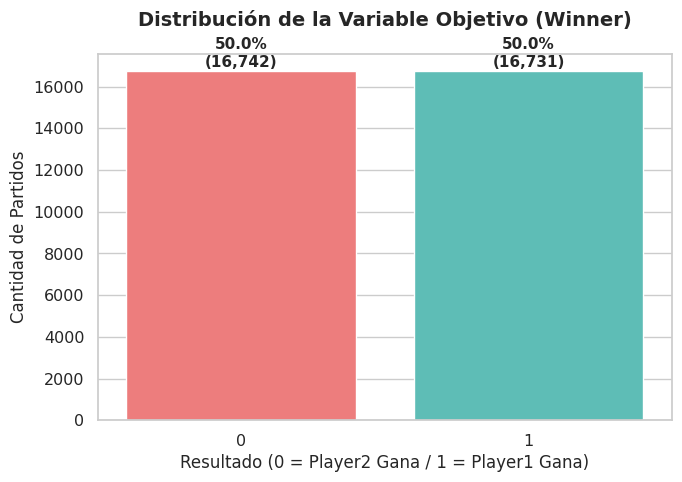

In [35]:
# Gráfico simple de la distribución de Winner
plt.figure(figsize=(7, 5))

# Crear el gráfico con el método correcto
ax = plt.gca()
sns.countplot(data=matches_train, x='winner', hue='winner', palette=['#FF6B6B', '#4ECDC4'], ax=ax, legend=False)

ax.set_title('Distribución de la Variable Objetivo (Winner)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Resultado (0 = Player2 Gana / 1 = Player1 Gana)', fontsize=12)
ax.set_ylabel('Cantidad de Partidos', fontsize=12)

# Añadir etiquetas con los porcentajes
total = len(matches_train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 225,
            f'{height/total:.1%}\n({int(height):,})',
            ha="center", fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show();

Vemos que la distribución de partidos ganados entre jugador1 y jugador2 es completamente aleatoria (50%), el modelo no puede aprender ningún patrón; e.g. "el jugador1 tiene más probabilidades de ganar, ya que gana el 65% de partidos".